In [190]:
#IMPORTS
%run ../datuslib.ipynb

In [191]:
#SETTINGS
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [192]:
#CARGA DATA

A_tweets = pd.read_csv(generateAbsolutePath("train.csv", exists = True))

In [193]:
#CARGA DE INTERNET PALBRAS NEGATIVAS

A_NEGATIVE_WORDS = getWordInListFromFile('negativeWords.txt')

# SE PLANTEA UN ANALISIS DE LA NEGATIVIDAD DE LOS TWEETS Y SU RELACION CON SI SON DESASTRES O NO

    Para esto se recurre a un analisis de frecuencias por palabras dependiendo de si es desastre o no y su relacion con las otras palabras. 
    
    Con esto lo que se quiere decir es que por la semantica misma, la palabra 'terremoto' es probable que sea usada seguido en desastres y poco en no desastres por lo que P(terremoto) seria una buena medida de negatividad
    
    En la misma linea, la palabra 'japon' quizas no sea semanticamente negativa pero tiene una alta probabilidad de ser negativa si en el mismo tweet figura 'terremoto' por lo que se puede definir negatividad contextual de japon con respecto a terremoto como P(japon | terremoto)P(terremto)
    
    Aplicando a cada tweet la suma de negatividades intrinsecas y contextuales se le asigna un numero que es la negatividad de ese tweet
    
    Para hacer un analisis con la intencion de que se comprenda la escencia de las palabras y no su escritura se lleva a cabo un preprocesamiento de las mismas
    
    Todo esto es provisto por la clase Context

In [194]:
#CREO EL OBJETO CONTEXT QUE CONTIENE TODA LA INFORMACION ESTADISTICA DE LAS INTERCONEXIONES DE PALABRAS EN TWEETS
context = Context(data = A_tweets, load = 'contextPLUS')

Data loaded
Texts loaded
Texts Tokens loaded
Clean Words loaded
Token Clean Words map loaded
Clean Words Token map loaded
Contextual map loaded
Disaster Frequency map loaded
Total Frequency map loaded
Negativity map loaded


In [195]:
#LO COMENTADO ES LO QUE SE USO PARA CALCULAR LA NEGATIVIDAD DE CADA TWEET EN TODO EL DATASET (35 mins aporx)

#A_tweets = A_tweets.copy().fillna(' ')
#A_tweets['negativity'] = A_tweets.apply(lambda row : getTweetNegativity(row,context), axis = 1)
#A_tweets.to_csv('tweets_con_negatividad.csv')

#SE CARGA EL DATASET PRE PROCESADO

A_tweets = pd.read_csv(generateAbsolutePath("tweets_con_negatividad.csv", exists = True))

# PLOT: P(desastre | nivel de negatividad = n)    para cada nivel de negatividad n (NAIVE)

In [196]:
#SE CALCULA P(desastre | negatividad = n) (tarda 50mins)

A_label = 'conditional probability of disaster given negativity'
#A_tweets[A_label] = A_tweets.apply(lambda row : probabilityOfGivenThat(isDisaster,
                                                                       #lambda x : x['coarse-grained negativity'] == row['coarse-grained negativity'],
                                                                      #A_tweetsTruncated), axis = 1)

#A_tweets = A_tweets.drop(columns = ['Unnamed: 0'])
#A_tweets.to_csv('tweets_truncados_con_probabilidad_condicional_dada_una_negatividad.csv')

#SE CARGA EL DATASET PRE PROCESADO

A_tweets = pd.read_csv(generateAbsolutePath("tweets_con_probabilidad_condicional_dada_una_negatividad.csv", exists = True))

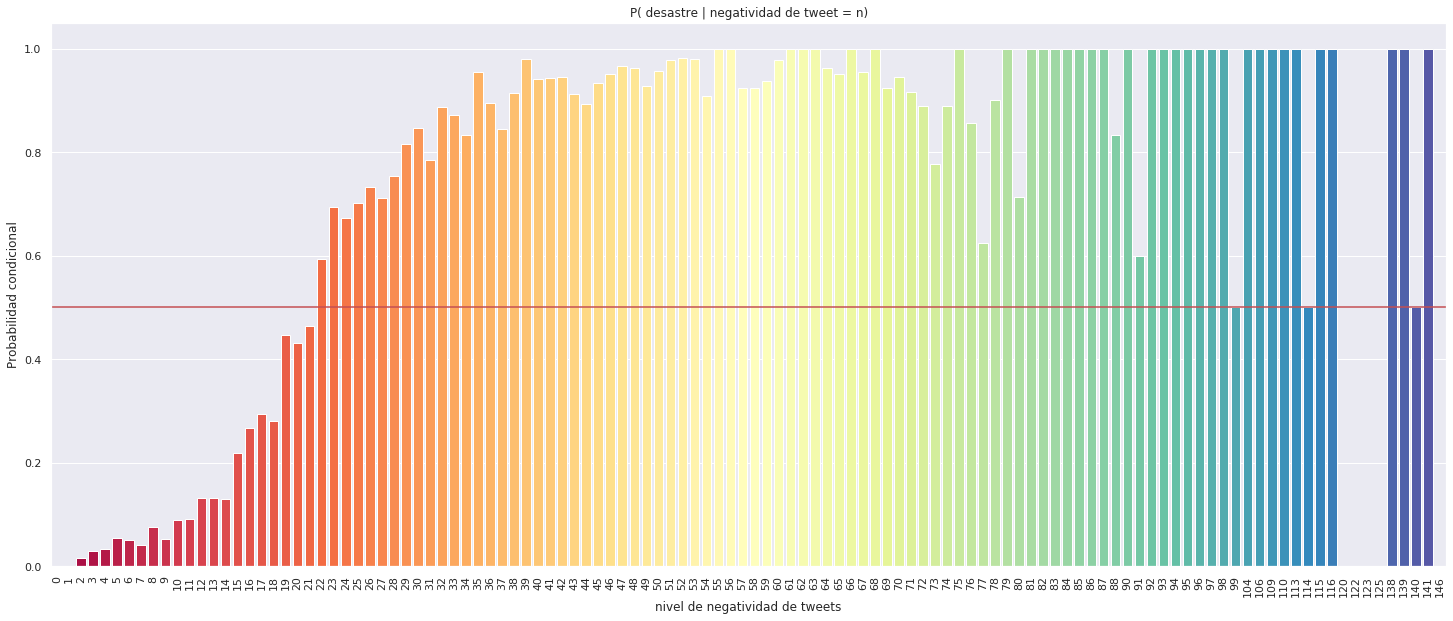

In [197]:
v = barplot(y = A_label, x = 'coarse-grained negativity', data = A_tweets, xLabel = 'nivel de negatividad de tweets', yLabel = 'Probabilidad condicional',
        title = 'P( desastre | negatividad de tweet = n)', fontSize = 1, xrotate = 90)

v.axhline(0.5, ls = '-', color = 'r')

# LA ECUACION MAS PELIGROSA DE LA HISTORIA

    Para no caer en el error de sacar conclusiones sobre caracteristicas de los datos sin tener en cuenta la cantidad de poseen esa caracteristica, se analiza la frecuencia de cada clase que forman los datos por sus diferentes niveles de negatividad y se truncan aquellos que no superan en frecuencia a la raiz cuadrada de la totalidad de los datos

In [198]:
truncatingValue = np.sqrt(A_tweets.groupby('negativity').count().shape[0])
print("RAIZ(N) = ",truncatingValue)

RAIZ(N) =  86.4291617453276


In [199]:
#BUSCANDO UNA CANTIDAD RAZONABLE SOBRE LA QUE DISCRETIZAR LOS DIFERENTES NIVELES DE NEGATIVIDAD

maxbins = A_tweets.groupby('negativity').count().shape[0]
print("maxbins: ",maxbins)

for bucketSize in range(1,11):
    A_tweets['coarse-grained negativity'] =  A_tweets.apply(lambda row : round(row['negativity']/bucketSize)*bucketSize, axis = 1)
    print("bucketSize: ",bucketSize,"bins: ",A_tweets.groupby('coarse-grained negativity').count().shape[0])

maxbins:  7470
bucketSize:  1 bins:  116
bucketSize:  2 bins:  65
bucketSize:  3 bins:  45
bucketSize:  4 bins:  35
bucketSize:  5 bins:  28
bucketSize:  6 bins:  24
bucketSize:  7 bins:  21
bucketSize:  8 bins:  19
bucketSize:  9 bins:  17
bucketSize:  10 bins:  15


In [200]:
#SE ELIGE EL bucketsize

bucketSize = 3
A_tweets['coarse-grained negativity'] =  A_tweets.apply(lambda row : round(row['negativity']/bucketSize)*bucketSize, axis = 1)

In [201]:
#SE CALCULA LA FRECUENCIA DE CADA CLASE DE NEGATIVIDAD

A_negativityFrec = A_tweets.copy()
A_negativityFrec['frecuency'] = 1
A_negativityFrec = A_negativityFrec.groupby('coarse-grained negativity').sum().reset_index()[['coarse-grained negativity','frecuency']]

# PLOT: Frecuencia en tweets de cada nivel de negatividad

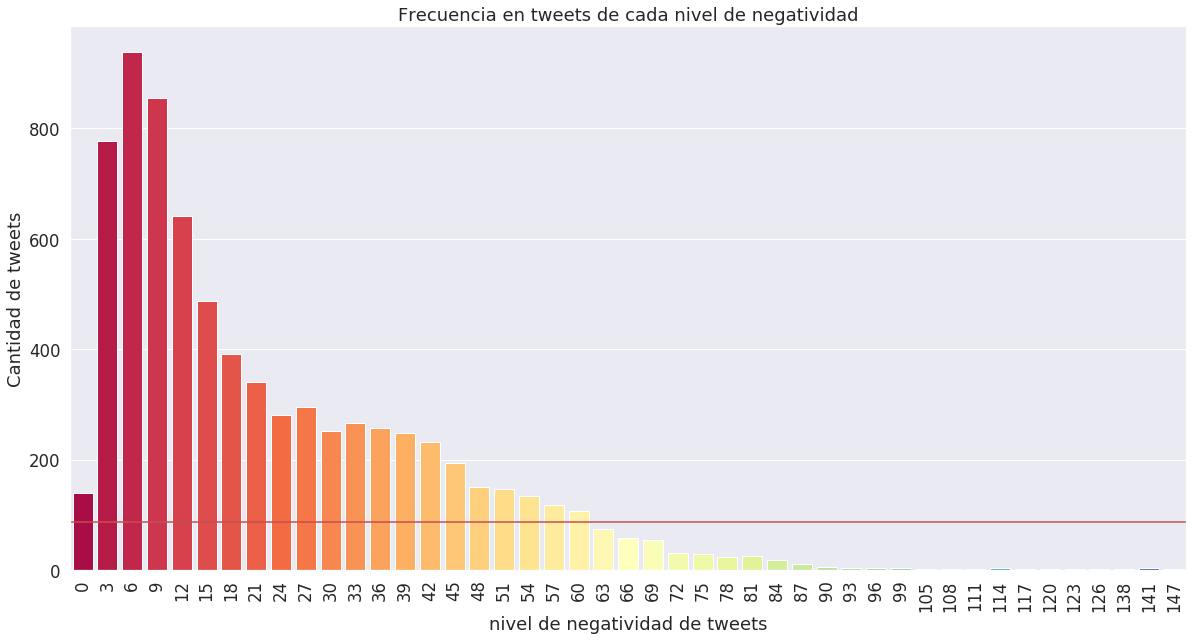

In [202]:
v = barplot(y = 'frecuency', x = 'coarse-grained negativity', data = A_negativityFrec, 
        xLabel = 'nivel de negatividad de tweets', yLabel = 'Cantidad de tweets',
        title = 'Frecuencia en tweets de cada nivel de negatividad', figY = 10, figX = 20,
        fontSize = 1.5, xrotate = 90)

v.axhline(truncatingValue, ls = '-', color = 'r')

# ANALISIS
    
    En el pltot se puede ver como la linea horizontal marca ese valor de raiz cuadrada de N y se ve como a partir de los tweets que tienen negatividad mayor a 60 tienen una frecuencia inferior a este valor.
    
    Visto esto se decide truncar todos los tweets cuyos valores de negatividad superen 60 para que las conclusiones estadisticas sobre los tweets resatantes sean razonable

In [203]:
#SE TRUNCAN LOS TWEETS CUYOS VALORES DE NEGATIVIDAD SUPERAN 60

truncatingValue = 60
A_tweets = A_tweets[ A_tweets['coarse-grained negativity'] <= truncatingValue]

# PLOT: P(desastre | nivel de negatividad = n)    para cada nivel de negatividad n

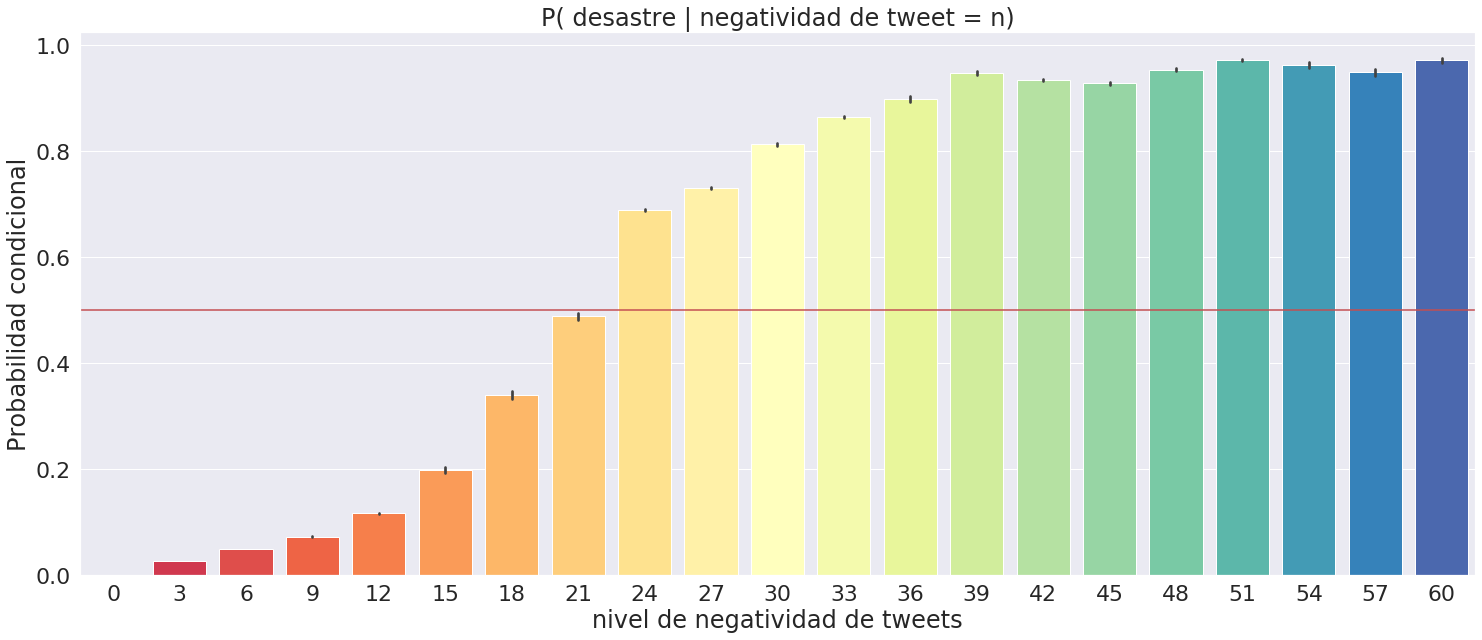

In [204]:
v = barplot(y = A_label, x = 'coarse-grained negativity', data = A_tweets, xLabel = 'nivel de negatividad de tweets', yLabel = 'Probabilidad condicional',
        title = 'P( desastre | negatividad de tweet = n)', fontSize = 2)

v.axhline(0.5, ls = '-', color = 'r')

# CONCLUSION
    
    Se puede ver que esta metrica artesanal de negatividad es monotona creicient con la 'desastrocidad' de los tweets, es decir, cuando mas alto da la negatividad, mas probable es que se trate de un desastre.
    
    Esto muestra que esta negatividad puede ser utilizada como indicador y potencialmente de predictor de desastre de un tweet basandose en su contenido
    
    Particularmente puede verse como a partir del nivel 20 de negatividad la probabilidad de desastre supera el 50% bruscamente. Uno podria clasificar un tweet como desastre o no desastre usando a este valor como medida

# SE ANALIZA LA PROBABILIDAD DE DESASTRE AL VARIAR LA LONGITUD DE TWEET
    
    Para esto se comienza eliminando ahora tambien los tweets cuyas clases de equivalencia en longitud no superan el valor de truncamineto definido anteriormente

In [211]:
#MOLDEANDO DATA

#(AGREGA) CAMPO DE TARGET CON NOMBRES MAS DETALLADOS QUE 1 o 0
A_tweets['Categoria'] = A_tweets.apply(lambda row : mapBinaryLabel(row['target'],['Desastre','No Desastre']), axis = 1)

#(AGREGA) CAMPO DE LONGITUD DE TWEETS
A_tweets['length'] = A_tweets.apply(lambda row : len(row['text']), axis = 1)

#(AGREGA) CAMPO DE PALABRAS NEGATIVAS
A_tweets['usa palabras negativas'] = A_tweets.apply(lambda row : mapBinaryLabel(hasCertainWords(row['text'],A_NEGATIVE_WORDS),['Usa Palabras Negativas','No Usa Palabras Negativas']), axis = 1)


In [212]:
#BUSCANDO UNA CANTIDAD RAZONABLE SOBRE LA QUE DISCRETIZAR LOS DIFERENTES NIVELES DE LONGITUD

maxbins = A_tweets.groupby('length').count().shape[0]
print("maxbins: ",maxbins)

for bucketSize in range(1,11):
    A_tweets['coarse-grained length'] =  A_tweets.apply(lambda row : round(row['length']/bucketSize)*bucketSize, axis = 1)
    print("bucketSize: ",bucketSize,"bins: ",A_tweets.groupby('coarse-grained length').count().shape[0])

maxbins:  145
bucketSize:  1 bins:  145
bucketSize:  2 bins:  73
bucketSize:  3 bins:  51
bucketSize:  4 bins:  38
bucketSize:  5 bins:  31
bucketSize:  6 bins:  26
bucketSize:  7 bins:  22
bucketSize:  8 bins:  20
bucketSize:  9 bins:  17
bucketSize:  10 bins:  16


In [213]:
#SE CALCULA LA FRECUENCIA DE CADA CLASE DE LONGITUD

A_lengthFrec = A_tweets.copy()
A_lengthFrec['frecuency'] = 2
A_lengthFrec = A_lengthFrec.groupby('coarse-grained length').sum().reset_index()[['coarse-grained length','frecuency']]

# PLOT: Distribucion de longitud de tweets

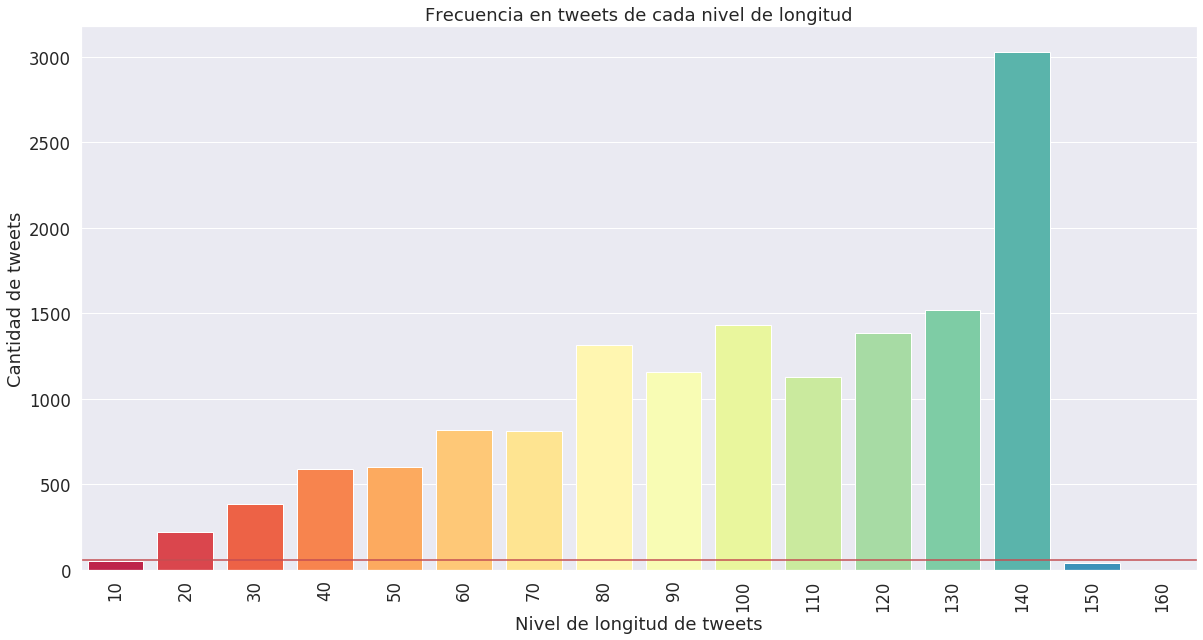

In [214]:
v = barplot(y = 'frecuency', x = 'coarse-grained length', data = A_lengthFrec, 
        xLabel = 'Nivel de longitud de tweets', yLabel = 'Cantidad de tweets',
        title = 'Frecuencia en tweets de cada nivel de longitud', figY = 10, figX = 20,
        fontSize = 1.5, xrotate = 90)

v.axhline(truncatingValue, ls = '-', color = 'r')

In [215]:
#SE ELIMINAN TWEETS EN CLASES DE LONGITUD CHICAS

A_tweets = A_tweets[ A_tweets.apply(lambda row : len(row['text']) >= 10 and len(row['text']) <= 150, axis = 1)]

# PLOT: Relacionando negatividad de los tweets y su longitud con si son desastres o no

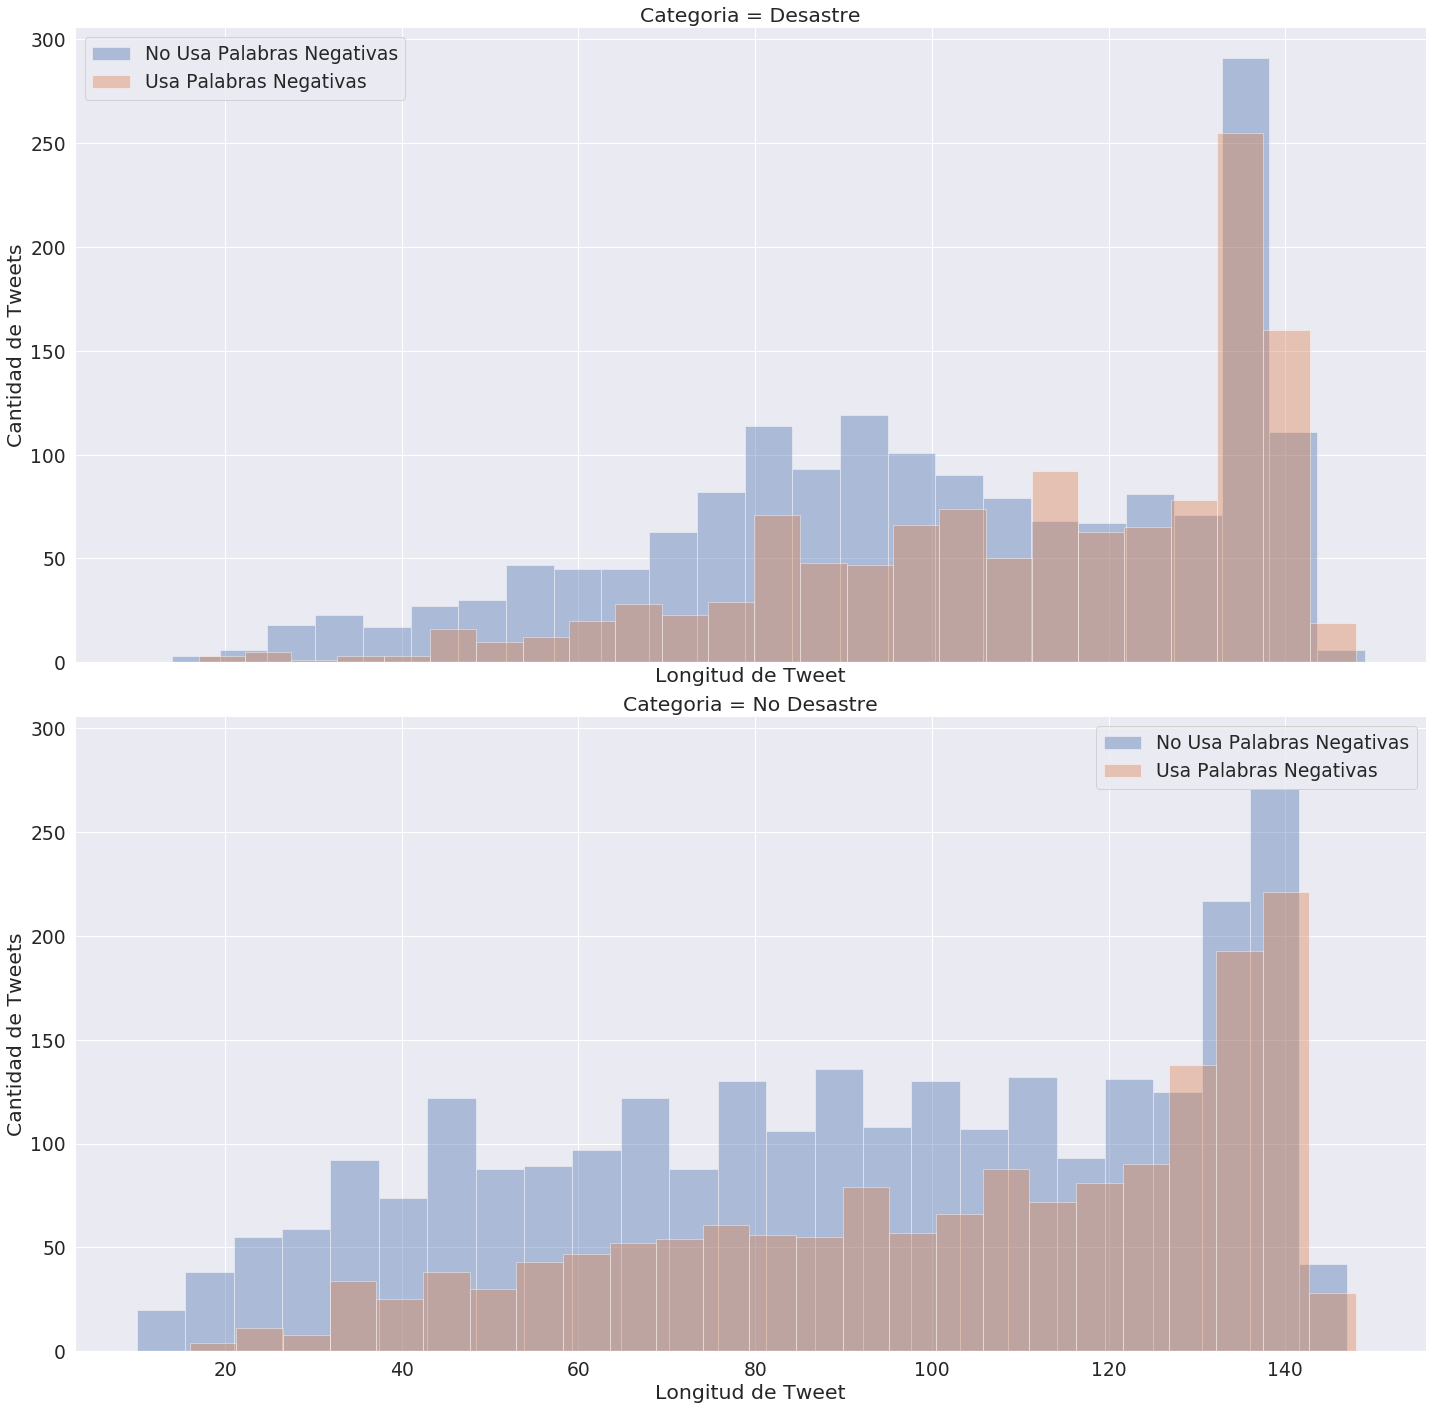

In [216]:
sns.set(font_scale = 1.7)
fg1 = sns.FacetGrid(A_tweets, hue = 'usa palabras negativas',row = 'Categoria', height = 10, aspect = 2)
v = fg1.map(sns.distplot, "length", kde = False, bins = 25 )


for ax in v.axes.ravel():
    ax.legend()
    ax.set(xlabel = 'Longitud de Tweet', ylabel = 'Cantidad de Tweets')

# Analisis: 

Parece que en el caso de los desastres no parece haber diferencia en los tweets en cuanto a si usa o no palabras negativas (salvo en aquellos de longitud media que parecen tener un pequeña tendencia a ser mas neutros que negativos)

Por otro lado, en el caso de los no desastres, es claro que predominan en cualquier longitud de tweet (salvo en los largos) los tweets neutros

# PLOT: P(desastre | longitud = l)    para longitud l

In [217]:
#SE CALCULA P(desastre | longitud = l) (tarda 50mins)

#A_label3 = 'conditional probability of disaster given length'
#A_tweets[A_label3] = A_tweets.apply(lambda row : probabilityOfGivenThat(isDisaster,
                                                                       #lambda x : x['coarse-grained length'] == row['coarse-grained length'],
                                                                      #A_tweets), axis = 1)

#A_tweets = A_tweets.drop(columns = ['Unnamed: 0'])
#A_tweets.to_csv('tweets_truncados_con_probabilidad_condicional_dada_una_longitud.csv')

#SE CARGA EL DATASET PRE PROCESADO

A_tweets = pd.read_csv(generateAbsolutePath("tweets_truncados_con_probabilidad_condicional_dada_una_longitud.csv", exists = True))

# PLOT: P(desastre | longitud = l)    para cada longitud l

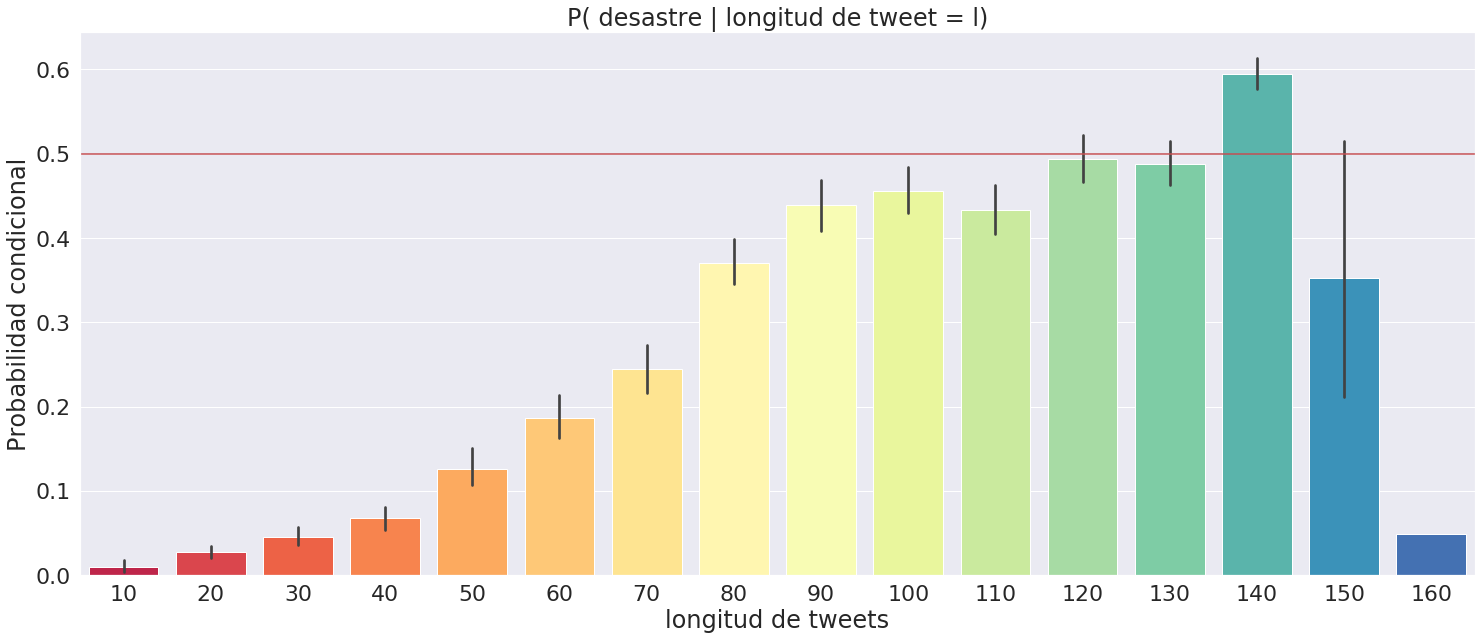

In [218]:
v = barplot(y = A_label, x = 'coarse-grained length', data = A_tweets, xLabel = 'longitud de tweets', yLabel = 'Probabilidad condicional',
        title = 'P( desastre | longitud de tweet = l)', fontSize = 2)

v.axhline(0.5, ls = '-', color = 'r')

# ANALISIS

    Se ve como en general la longitud de tweet no es un buen indicador de desastre nunca. Mas aun, tal como se habia analizado antes en el density plot, pareciera que mas bien es un indicador de no desastre.
    
    El unico caso donde probabilidad superior a 1/2 y alta frecuencia coinciden es en los tweets de 140 caracteres. En este caso es posible decir que estos son mas propensos a ser desastres

# PROBABILIDAD DE DESASTRE COMBINANDO LONGITUD Y NEGATIVIDAD

    La idea ahora es combinar ambas metricas y ver para que pares (negatividad, longitud) 
    P( desastre | N = y L = l)

In [219]:
#SE CALCULA P(desastre | longitud = l) (tarda 50mins)

#A_label2 = 'conditional probability of disaster given negativity and length'
#A_tweets[A_label2] = A_tweets.apply(lambda row : probabilityOfGivenThat(isDisaster,
                                                     #lambda x : x['coarse-grained negativity'] == row['coarse-grained negativity'] and x['coarse-grained length'] == row['coarse-grained length'],
                                                     #A_tweetsTruncated), axis = 1)

#A_tweets =  A_tweets.drop(columns = ['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'])
#A_tweets.to_csv('tweets_truncados_con_probabilidad_condicional_dada_una_negatividad_y_longitud.csv')

#SE CARGA EL DATASET PRE PROCESADO

A_tweets = pd.read_csv(generateAbsolutePath("tweets_truncados_con_probabilidad_condicional_dada_una_negatividad_y_longitud.csv", exists = True))

# PLOT: Distribucion de los datos en las dimensiones de negatividad y longitud

    De alguna forma, las zonas mas densas son las mas confiables para el calculo de la probabilidad condional de P(desastre | negatividad = n y logitud = l)

Text(0.5, 1, 'Distribucion de tweets considerando sus longitudes y negatividad')

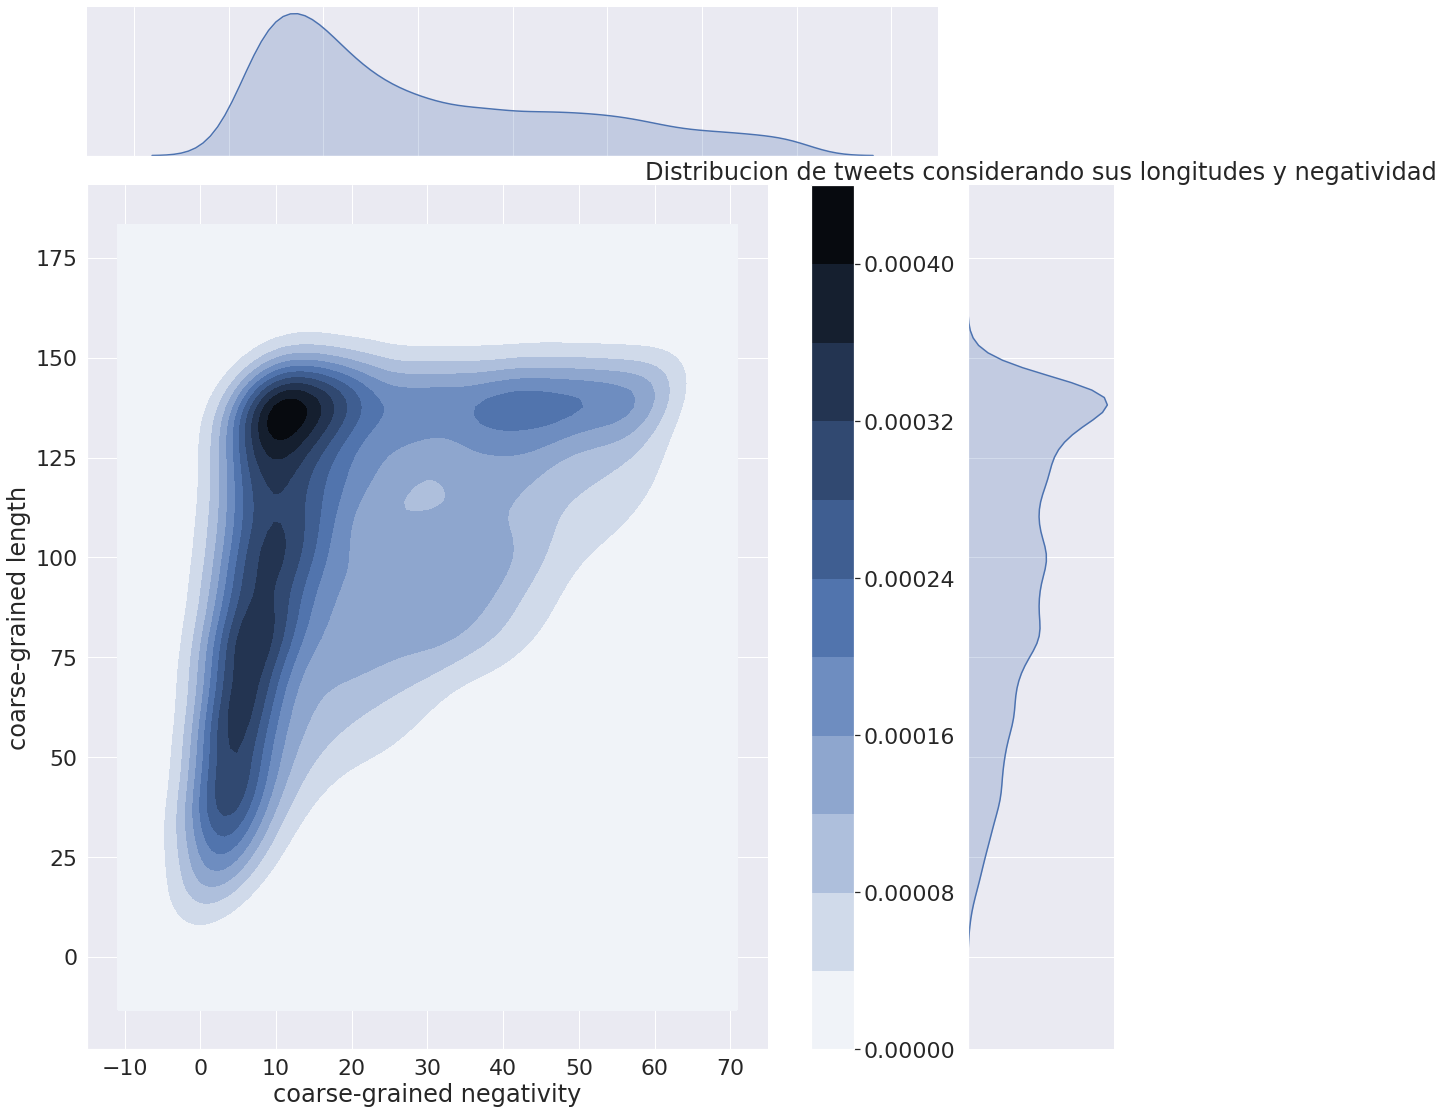

In [220]:
v = sns.jointplot("coarse-grained negativity", "coarse-grained length", data=A_tweets, kind = "kde",
             height = 16, cbar = True)
plt.title('Distribucion de tweets considerando sus longitudes y negatividad')

In [221]:
A_heatMapProbabilityNegativityLength = A_tweets.groupby(['coarse-grained negativity','coarse-grained length']).min().reset_index()

A_heatMapProbabilityNegativityLength = A_heatMapProbabilityNegativityLength.pivot(
                                                      'coarse-grained length',
                                                      'coarse-grained negativity',
                                                      'conditional probability of disaster given negativity and length')

# PLOT: Probabilidad condicional de desastre por cada par de negatividad y longitud

[Text(0.5, 1, 'P(tweet es desastre | negatividad = n y longitud = l)')]

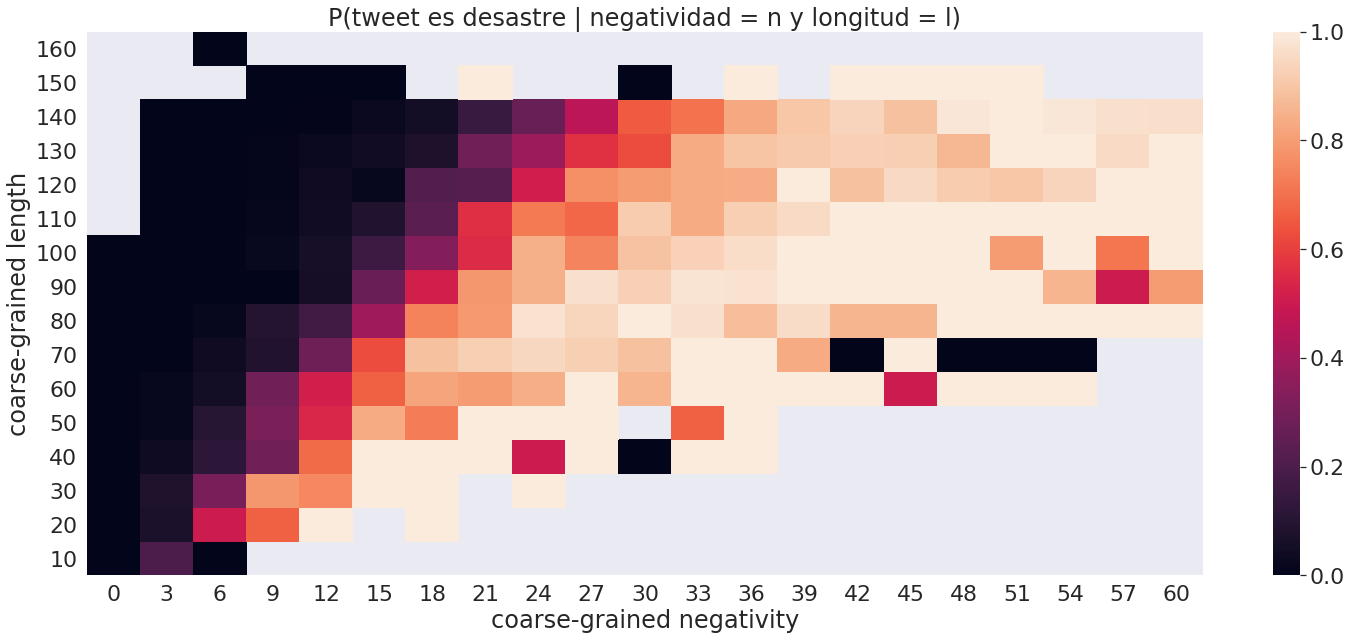

In [222]:
v = sns.heatmap(A_heatMapProbabilityNegativityLength)
v.invert_yaxis()
v.set(title = 'P(tweet es desastre | negatividad = n y longitud = l)')

# ANALISIS:

    Se pueden ver valores altos de probabilidad en la derecha superior del grafico. Lamentablemete esas zonas no son las mas pobladas por los datos por lo que el nivel de confianza en esta probabilidad es bajo.
    
    Si hubiese que arriesgar con quedarse con alguna zona, la mas prometedora es el centro. Esto es porque el centro posee un poblamiento de los datos moderado y corresponde a una zona de probabilidad elevada
    
    Esto significaria que un tweet con una longitd de entre 125 y 75 caracteres y de una negatividad de entre 20 y 40 puntos tiene con cierta confianza moderada, una probabilidad significativa de ser un desastre
    
    La dificultad de asignar una metrica confiable radica en parte sobre el hecho de que la longitud en si ya no parece una buena metrica

# SE ANALIZA LA POSIBILIDAD DE QUE LA IMPORTANCIA INFLUYA EN LA PROBABILIDAD DE DESASTRE

In [223]:
A_tweets = A_tweets.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1','Unnamed: 0.1.1'])

In [224]:
#(AGREGA) CAMPO DE IMPORTANCIA DE TWEETS
A_tweets['importance'] = A_tweets.apply(lambda row : calculateTweetImportance(row), axis = 1)

#BUSCANDO UNA CANTIDAD RAZONABLE SOBRE LA QUE DISCRETIZAR LOS DIFERENTES NIVELES DE IMPORTANCIA
A_tweets['coarse-grained importance'] =  A_tweets.apply(lambda row : round(row['importance'],1), axis = 1)
print("bucketSize: ",bucketSize,"bins: ",A_tweets.groupby('coarse-grained importance').count().shape[0])

importanceProbabilityMap = probabilitiesOfGivenX(isDisaster,'coarse-grained importance',A_tweets)

bucketSize:  10 bins:  53


# PLOT: Distribucion de tipos de importancia 

In [225]:
#SE CALCULA LA FRECUENCIA DE CADA CLASE DE LONGITUD

A_importanceFrec = A_tweets.copy()
A_importanceFrec['frecuency'] = 2
A_importanceFrec = A_importanceFrec.groupby('coarse-grained importance').sum().reset_index()[['coarse-grained importance','frecuency']]

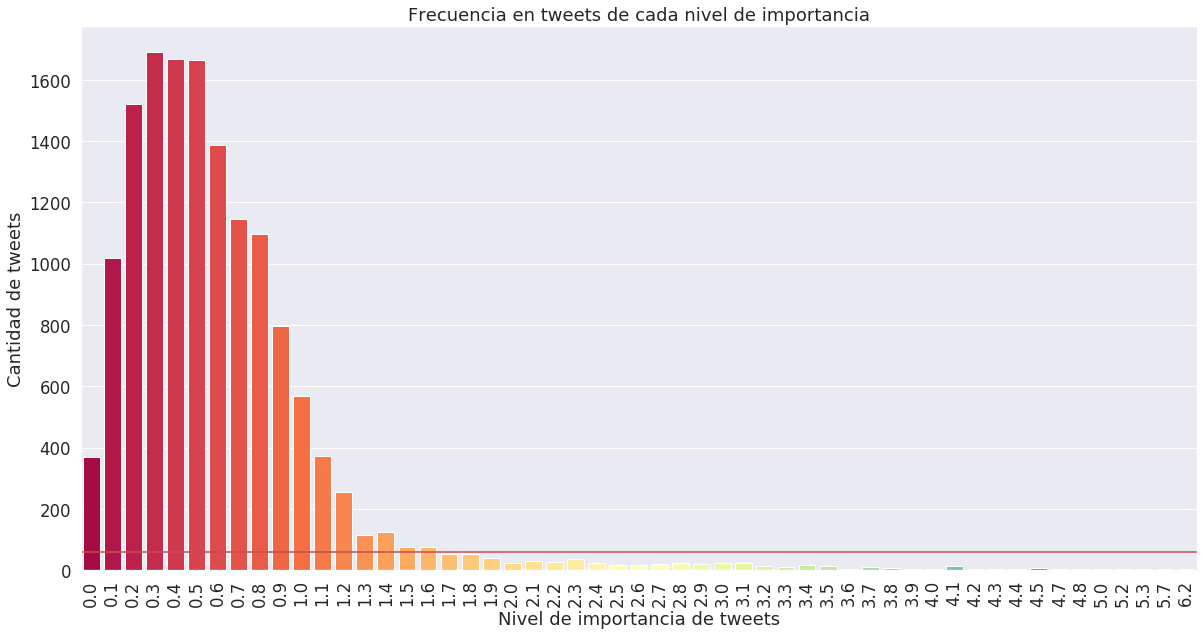

In [226]:
v = barplot(y = 'frecuency', x = 'coarse-grained importance', data = A_importanceFrec, 
        xLabel = 'Nivel de importancia de tweets', yLabel = 'Cantidad de tweets',
        title = 'Frecuencia en tweets de cada nivel de importancia', figY = 10, figX = 20,
        fontSize = 1.5, xrotate = 90)

v.axhline(truncatingValue, ls = '-', color = 'r')

In [227]:
A_tweets['probability of disaster given importance'] = A_tweets.apply(lambda row : importanceProbabilityMap[row['coarse-grained importance']], axis = 1)

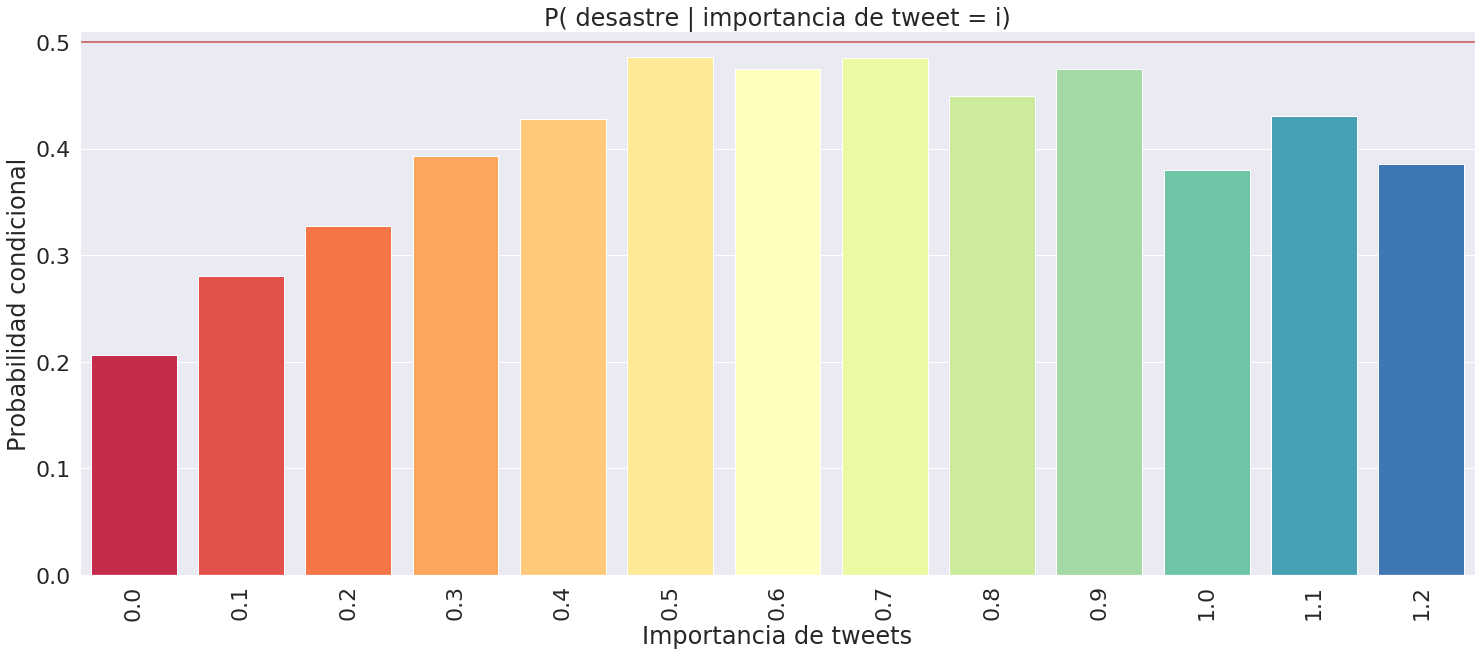

In [228]:
v = barplot(y = 'probability of disaster given importance', x = 'coarse-grained importance', 
            data = A_tweets[A_tweets['coarse-grained importance'] <= 1.2], 
            xLabel = 'Importancia de tweets', yLabel = 'Probabilidad condicional',
        title = 'P( desastre | importancia de tweet = i)', fontSize = 2, xrotate = 90)

v.axhline(0.5, ls = '-', color = 'r')

# ANALISIS:

    Se puede ver que en las zonas donde la importancia tiene baja frecuencia la probabilidad es 0 o 1 de forma discontinua. Esto evidencia el problema tipico de 'la ecuacion mas peligrosa de la historia'
    
    Por otro lado en la zona de frecuencia mas alta se puede ver que la probabilidad esta casi siempre por debajo de 1/2, por lo que esta medicion, si midiese algo, mediria la probabilidad de no desastre (tal como pasaba con la longitud)
    
    El siguiente paso seria comparar la negatividad con la importancia y la importancia con la longitud pero dado el resultado que dio combinar la negatividad con la longitud (siendo esta una mala herramienta de medicion), se podria esperar tambien un resultado negativo similar
    
    Resumiendo entonces, la importancia pareciera no importar para saber si el tweet es desastre o no

# PROBABILIDAD DE DESASTRE COMBINANDO IMPORTANCIA Y NEGATIVIDAD

    La idea ahora es combinar ambas metricas y ver para que pares (negatividad, importancia) 
    P( desastre | N = n y I = i)

# PLOT: Distribucion de los datos en las dimensiones de negatividad e Importancia

Text(0.5, 1, 'Distribucion de tweets considerando su importancia y negatividad')

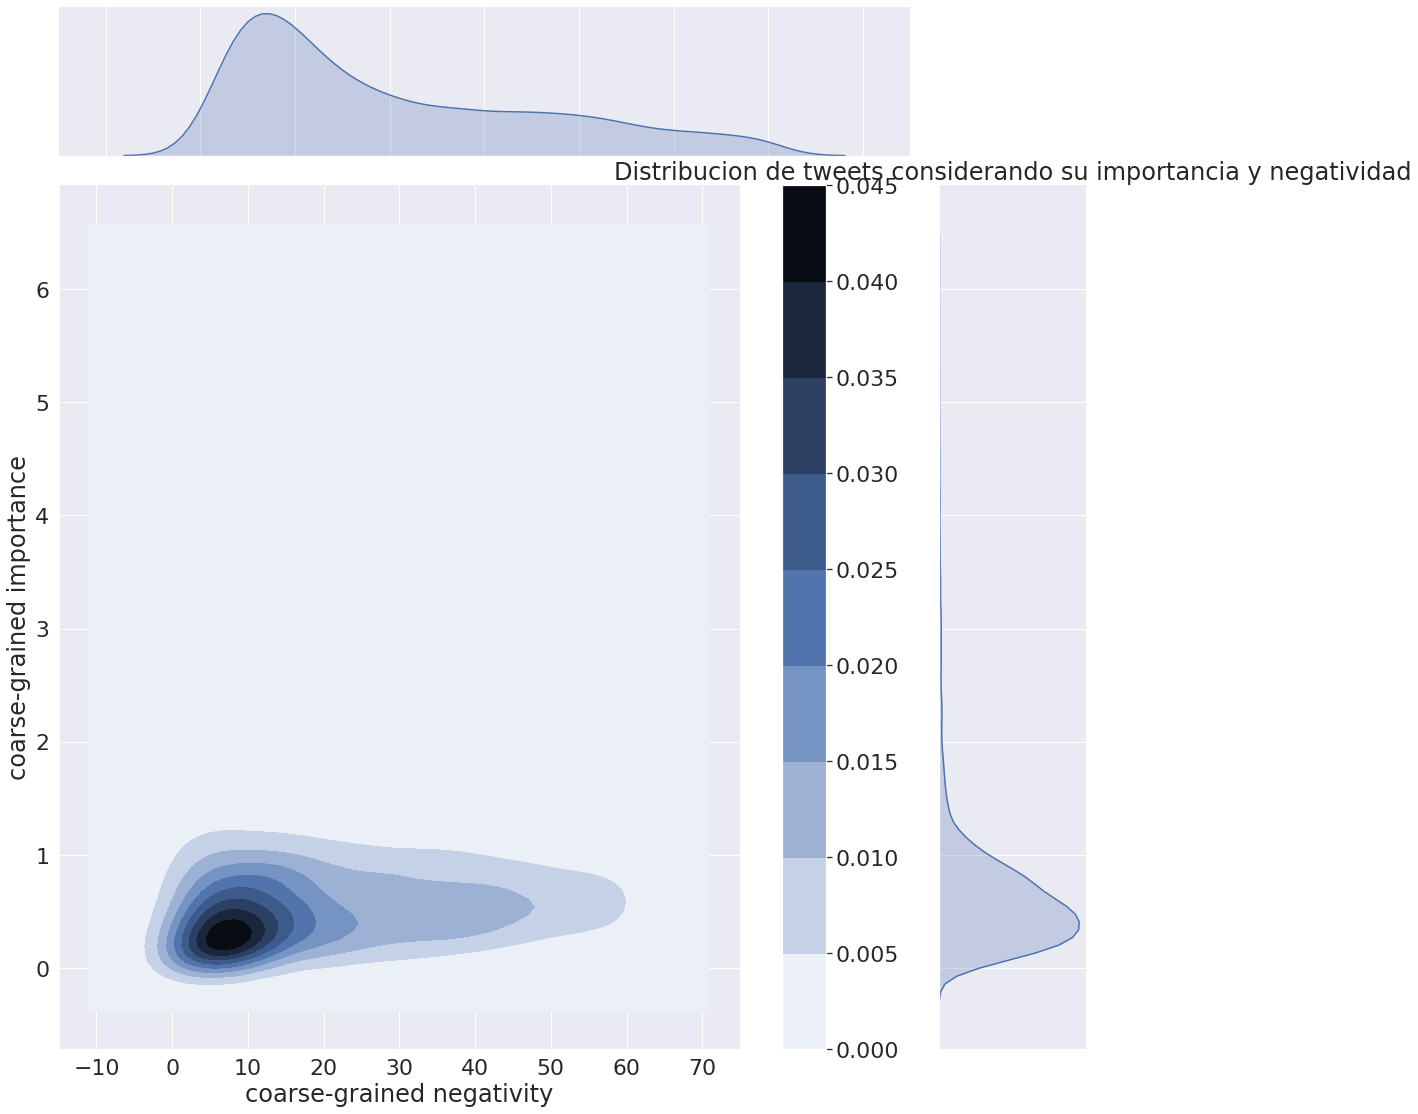

In [229]:
v = sns.jointplot("coarse-grained negativity", "coarse-grained importance", data=A_tweets, kind = "kde",
             height = 16, cbar = True)
plt.title('Distribucion de tweets considerando su importancia y negatividad')

In [230]:
#A_probs = probabilitiesOfGivenXY(isDisaster,'coarse-grained negativity','coarse-grained importance',A_tweets)

In [231]:
#A_tweets['probability of disaster given negativity and importance'] = A_tweets.apply(lambda row : A_probs[row['coarse-grained negativity']][row['coarse-grained importance']], axis = 1)

In [232]:
#A_tweets.to_csv('tweets_con_probabilidad_condicional_dada_una_negatividad_e_importancia.csv')

In [234]:
A_tweets = pd.read_csv(generateAbsolutePath('tweets_con_probabilidad_condicional_dada_una_negatividad_e_importancia.csv', exists = True))

In [235]:
A_heatMapProbabilityNegativityImportance = A_tweets.groupby(['coarse-grained negativity','coarse-grained importance']).min().reset_index()

A_heatMapProbabilityNegativityImportance = A_heatMapProbabilityNegativityImportance.pivot(
                                                      'coarse-grained importance',
                                                      'coarse-grained negativity',
                                                      'probability of disaster given negativity and importance')

# PLOT: Probabilidad condicional de desastre por cada par de negatividad e Importancia

[Text(0.5, 1, 'P(tweet es desastre | negatividad = n y importancia = i)')]

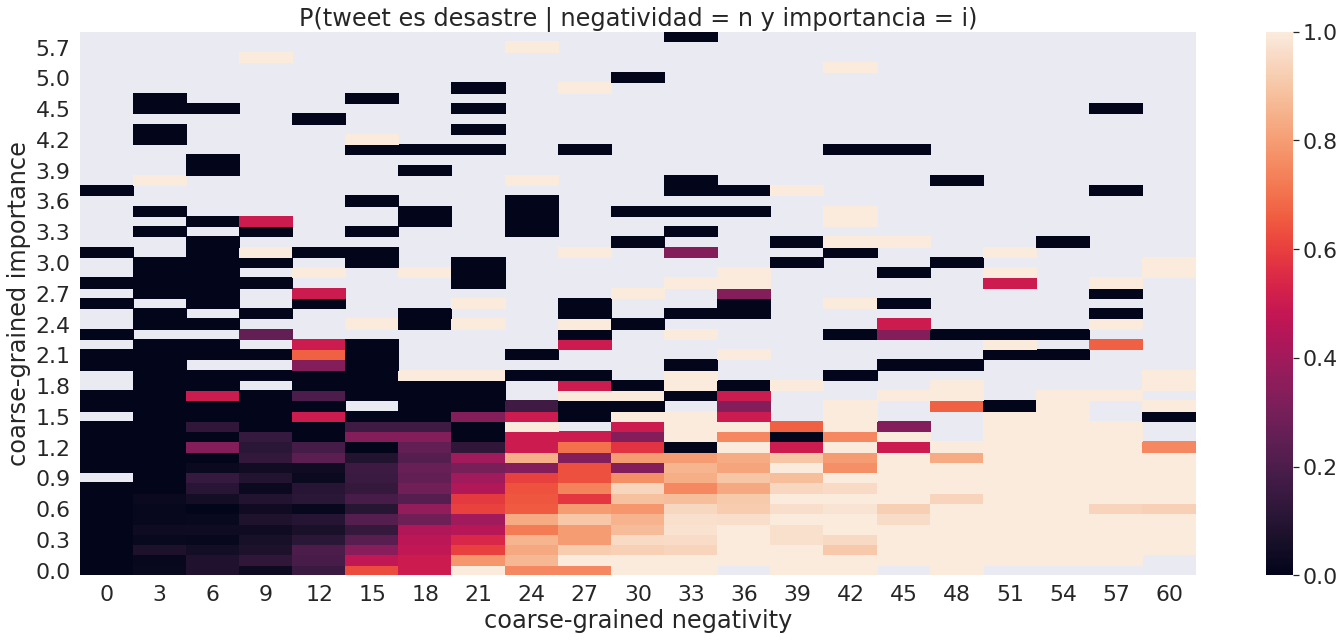

In [236]:
v = sns.heatmap(A_heatMapProbabilityNegativityImportance)
v.invert_yaxis()
v.set(title = 'P(tweet es desastre | negatividad = n y importancia = i)')

# PROBABILIDAD DE DESASTRE COMBINANDO IMPORTANCIA Y LONGITUD

    La idea ahora es combinar ambas metricas y ver para que pares (negatividad, importancia) 
    P( desastre | L = l I = i)

# PLOT: Distribucion de los datos en las dimensiones de longitud e Importancia

Text(0.5, 1, 'Distribucion de tweets considerando su importancia y longitud')

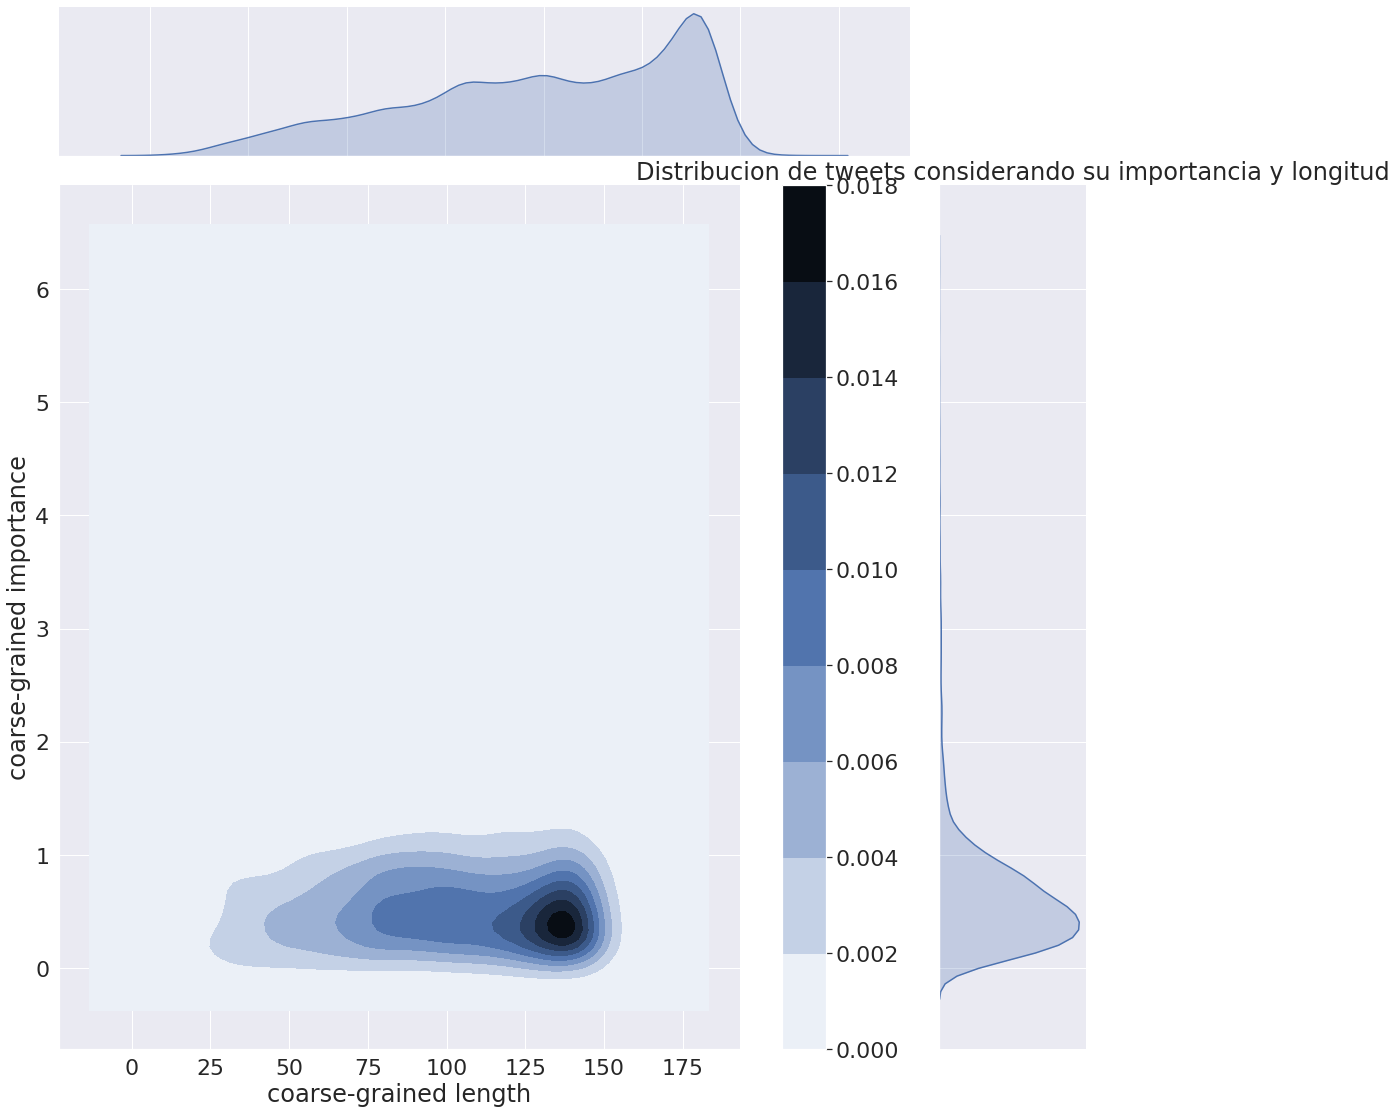

In [237]:
v = sns.jointplot("coarse-grained length", "coarse-grained importance", data=A_tweets, kind = "kde",
             height = 16, cbar = True)
plt.title('Distribucion de tweets considerando su importancia y longitud')

In [238]:
A_probsL = probabilitiesOfGivenXY(isDisaster,'coarse-grained length','coarse-grained importance',A_tweets)

In [239]:
A_tweets['probability of disaster given length and importance'] = A_tweets.apply(lambda row : A_probsL[row['coarse-grained length']][row['coarse-grained importance']], axis = 1)

In [240]:
A_tweets.to_csv('tweets_con_probabilidad_condicional_dada_una_longitud_e_importancia.csv')

In [241]:
A_tweets = pd.read_csv(generateAbsolutePath('tweets_con_probabilidad_condicional_dada_una_longitud_e_importancia.csv', exists = True))

In [247]:
A_heatMapProbabilityLengthImportance = A_tweets.groupby(['coarse-grained length','coarse-grained importance']).min().reset_index()

A_heatMapProbabilityLengthImportance = A_heatMapProbabilityLengthImportance.pivot(
                                                      'coarse-grained importance',
                                                      'coarse-grained length',
                                                      'probability of disaster given length and importance')

# PLOT: Probabilidad condicional de desastre por cada par de Longitud e Importancia

[Text(0.5, 1, 'P(tweet es desastre | longitud = l y importancia = i)')]

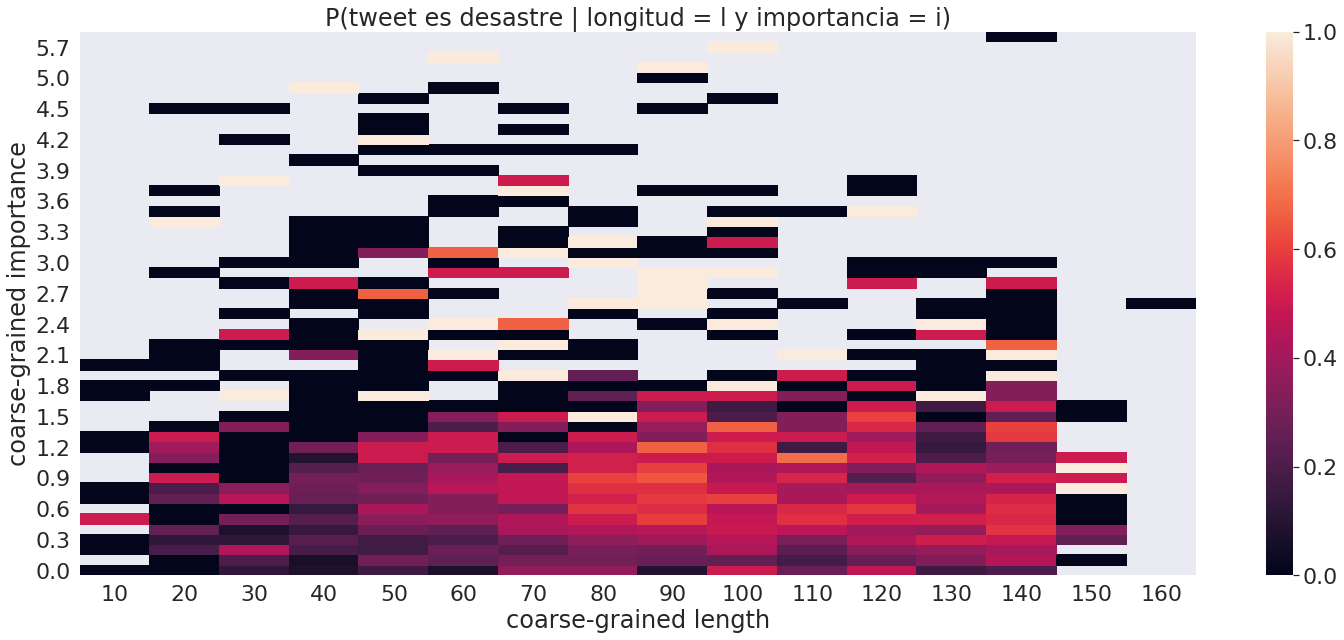

In [248]:
v = sns.heatmap(A_heatMapProbabilityLengthImportance)
v.invert_yaxis()
v.set(title = 'P(tweet es desastre | longitud = l y importancia = i)')